# Utility Functions

In [1]:
def prepare_and_load_dataset(base_dir):
    # images are expected to be jpg and in subfolders of base_dir (no nested subfolders)
    from PIL import Image
    import glob
    import os.path
    import re

    resized_suffix = '_resized'

    size = (240, 160)
    images = []
    labels = []
    for filename in glob.glob(base_dir + '*/*.jpg'):
        if resized_suffix not in filename: # make sure we don't process the files we already resized
            resized_filename = os.path.splitext(filename)[0] + resized_suffix + '.jpg'
            if not os.path.isfile(resized_filename):
                image = Image.open(filename)
                image = image.resize(size, Image.ANTIALIAS)
                image.save(resized_filename, "JPEG")
            images.append(Image.open(resized_filename))
            labels.append(re.split("[/\\\]", filename)[-2])
        else:
            pass

    print("prepared " + str(len(images)) + " images")

    return images, labels

def evaluate(X, y, predicted, n_clusters, name):
    X_reduced = PCA(n_components=2).fit_transform(X)
    cmap = cm.get_cmap('jet', lut=n_clusters)
    plt.figure()
    plt.title(name)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=predicted, cmap=cmap, alpha=.9)
    plt.colorbar(ticks=range(n_clusters))
    plt.show()
    vmeasure = metrics.v_measure_score(y, predicted);
    print(f'V-Measure = {vmeasure}')

def store_clusters(base_dir, images, clusters, clear_directory=False):
    # expects list of images and list of clusters (=label) to be same size
    if clear_directory and os.path.exists(base_dir): shutil.rmtree(base_dir)
    # create sorted list of (<image>, <cluster>) pairs
    images_by_cluster = sorted(zip(images, clusters), key=lambda x: x[1])         
    for image, cluster in images_by_cluster: # save images in a directory per cluster
        cluster_dir = base_dir + str(cluster)
        if not os.path.exists(cluster_dir):
            os.makedirs(cluster_dir)
        image_name = cluster_dir + '/' + re.split("[/\\\]", image.filename)[-1]
        image.save(image_name, 'JPEG')

# Feature Extraction Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

sample_images = [3, 13, 52, 151, 212]

def extract_hsv_features(images, visualise=False):
    bins_h = 10
    bins_s = 5
    bins_v = 5
    n_features = bins_h + bins_s + bins_v
    features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

    for i, image in enumerate(images):
        hsv = image.convert('HSV');
        h_hist, h_bins = np.histogram(hsv.getchannel('H'), bins=bins_h)
        s_hist, s_bins = np.histogram(hsv.getchannel('S'), bins=bins_s)
        v_hist, v_bins = np.histogram(hsv.getchannel('V'), bins=bins_v)
        features[i] = np.concatenate([h_hist, s_hist, v_hist])

        if visualise and i in sample_images:
            plt.figure(figsize=(10, 3))
            plt.subplot(121)
            plt.imshow(image)
            plt.subplot(122)
            plt.bar(h_bins[:-1], h_hist, alpha=.7, label='h', width=255/bins_h)
            plt.bar(s_bins[:-1], s_hist, alpha=.7, label='s', width=255/bins_s)
            plt.bar(v_bins[:-1], v_hist, alpha=.7, label='v', width=255/bins_v)
            plt.legend()   
            plt.show()     

    return features

def extract_rgb_features(images, visualise=False):
    bins_r = 10
    bins_g = 10
    bins_b = 10
    n_features = bins_r + bins_g + bins_b
    features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

    for i, image in enumerate(images):
        r_hist, r_bins = np.histogram(image.getchannel('R'), bins=bins_r)
        g_hist, g_bins = np.histogram(image.getchannel('G'), bins=bins_g)
        b_hist, b_bins = np.histogram(image.getchannel('B'), bins=bins_b)
        features[i] = np.concatenate([r_hist, g_hist, b_hist])

        if visualise and i in sample_images:
            plt.figure(figsize=(10,3))
            plt.subplot(121)
            plt.imshow(image)
            plt.subplot(122)
            plt.bar(r_bins[:-1], r_hist, alpha=.7, color='r', width=255/bins_r)
            plt.bar(g_bins[:-1], g_hist, alpha=.7, color='g', width=255/bins_g)
            plt.bar(b_bins[:-1], b_hist, alpha=.7, color='b', width=255/bins_g)
            plt.show()

    return features

def extract_edge_features(images, histogram=False, visualise=False):
    # using the histogram gives way worse results!
    n_bins = 20
    n_features = n_bins if histogram else 400 # 10x10 cells with 4 orientations each
    features = np.zeros(shape=(len(images), n_features)) # initialize feature matrix

    for i, image in enumerate(images):
        grayscale = np.array(image.convert('L'))
        fd, hog_image = hog(grayscale, orientations=4, pixels_per_cell=(24, 16),
                        cells_per_block=(10, 10), block_norm='L2', visualise=True, 
                        feature_vector=True) #cells_per_block 10x10 vs 1x1
                           
        
        edge_hist, edge_bins = np.histogram(fd, bins=n_bins)
        features[i] = edge_hist if histogram else fd

        if visualise and i in sample_images: 
            # rescale image for better colors/display
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            plt.figure(figsize=(15, 3))
            plt.subplot(131)
            plt.imshow(image)
            plt.subplot(132)
            plt.imshow(hog_image_rescaled, cmap='gray')
            plt.subplot(133)
            plt.hist(fd)
            plt.show()
            
    return features
#TODO merge etc die clsuters anpassen, und dann die als label zu supervised_ITML geben! :D sollte funzen, nah?


## Distance Metrics

In [31]:
def euclidean_distance(X):  
    n_samples = X.shape[0]
    distanceMatrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            distanceMatrix[i, j] = np.linalg.norm(X[i, :] - X[j, :]) # euclidean distance
    return distanceMatrix

def distance_to_similarity(distanceMatrix, beta=.5): # TODO ITML paper uses squared euclidean distance here and also after the featrue transofmratiokn!
    # sklearn proposes to use similarity isntead of distance for spectral clustering
    # beta = .5 seems to yield the best results, in paper they use 1
    similarityMatrix = np.exp(-beta * distanceMatrix / distanceMatrix.var())
    return similarityMatrix


def learn_distance(X, similarityConstraints, dissimilarityConstraints,
                   return_similarity=True, verbose=True):
    from metric_learn import ITML
    itml = ITML(verbose=verbose)
    itml = itml.fit(X, constraints=(
                    similarityConstraints[:, 0], similarityConstraints[:, 1],
                    dissimilarityConstraints[:, 0], dissimilarityConstraints[:, 1]))
    X_transformed = itml.transform()
    if return_similarity:
        return distance_to_similarity(euclidean_distance(X_transformed))
    else: return X_transformed


## Main program

In [4]:
import re, shutil, os, itertools
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn import metrics
from matplotlib import cm
%matplotlib inline

# prepare and load data
images, labels = prepare_and_load_dataset('c:/clustering/dataset/')

prepared 229 images


In [5]:
# extract features
rgb_features = extract_rgb_features(images, visualise=False)
hsv_features = extract_hsv_features(images, visualise=False)
edge_features = extract_edge_features(images, histogram=False, visualise=False)

# build feature matrix X
X = np.column_stack([hsv_features, edge_features])
y = np.array(labels)
print(f'feature matrix X shape: {X.shape}')
print(f'label vector y shape:   {y.shape}')

feature matrix X shape: (229, 420)
label vector y shape:   (229,)


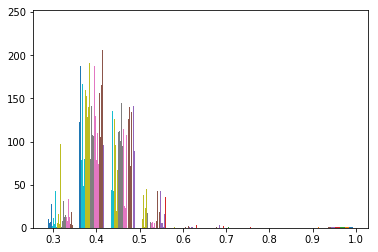

In [381]:
# normalize features
X = scale(X)

similarityMatrix = create_similarity

plt.hist(similarityMatrix)
plt.show()

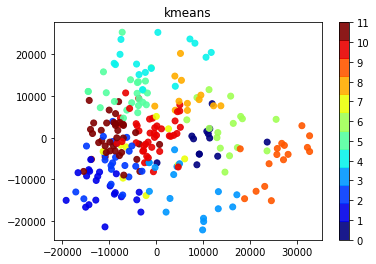

V-Measure = 0.3132404772968404


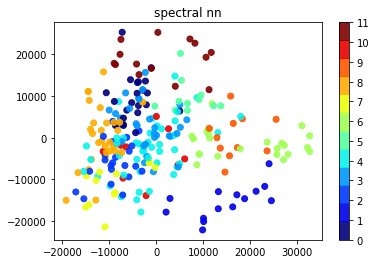

V-Measure = 0.32816879397373083


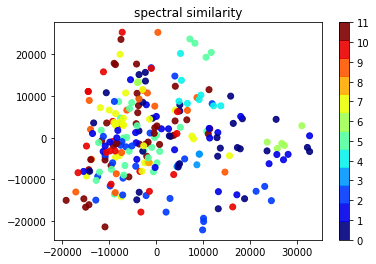

V-Measure = 0.2238147536033269


In [392]:
# cluster the images
n_clusters = 12

p_kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(X)
p_spectral_nn = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors").fit_predict(X)
p_spectral_sim = SpectralClustering(n_clusters=n_clusters, affinity="precomputed").fit_predict(similarityMatrix)

for name, predicted_clusters in {'kmeans': p_kmeans, 'spectral nn': p_spectral_nn, 'spectral similarity': p_spectral_sim}.items():
    evaluate(X, y, predicted_clusters, n_clusters, name)


In [53]:
# cluster operations
def merge(clusters, a, b): #todo could also return similarity/dissimilarity constraints. but what then..?
    # expects clusters to be list of labels, a and b label to be merged
    # TODO should clusters be tha "ground truths" (labels, y) or predictions..?
    #--> guess the result from prev. clsutering operation (starting with euclidean)
    #similarityMatrix = similarityMatrix.copy()
    #clusters = clusters.copy()
    indices = [i for i, cluster in enumerate(clusters) if cluster == a or cluster == b]
    similarityConstraints = np.array(list(itertools.combinations(indices, 2)))
    dissimilarityConstraints = np.array([(0, 0)]) #dummy
    """
    for i in range(len(clusters)):
        if (clusters[i] == a or clusters[i] == b):
            similarityConstraints.append()
        
    
    for i in range(len(similarityMatrix)):
        for j in range(len(similarityMatrix)):
            if (clusters[i] == clusters[j]):
                similarityMatrix[i,j] = 1
                #TODO what exactly should we do here? increase similarity, or set it to fixed val? --> guess 1 is a good choice
    """
    return similarityConstraints, dissimilarityConstraints

def move(similarityMatrix, clusters, elem, target_cluster): # TODO does not rly work somehow..
    similarityMatrix = similarityMatrix.copy()
    clusters = clusters.copy()
    clusters[elem] = target_cluster
    for i in range(len(similarityMatrix)):
        if clusters[i] == target_cluster:
            similarityMatrix[elem,i] = 1 # TODO rly set it to 1?
            similarityMatrix[i,elem] = 1
        else:
            similarityMatrix[elem,i] = 0 # TODO rly set it to 0? maybe just decrease, since we not sure if theyre actually in same cluster
            similarityMatrix[i,elem] = 0
    return similarityMatrix, clusters

    
def split(similarityMatrix, clusters, c):
    similarityMatrix = similarityMatrix.copy()
    clusters = clusters.copy()
    #TODO
    return similarityMatrix, clusters
    

In [482]:
#store_clusters('c:/clustering/result/', images, p_spectral_sim, clear_directory=True)


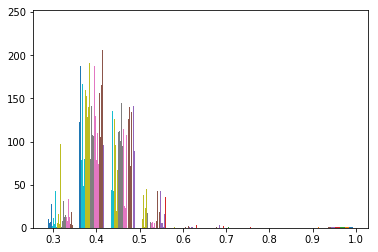

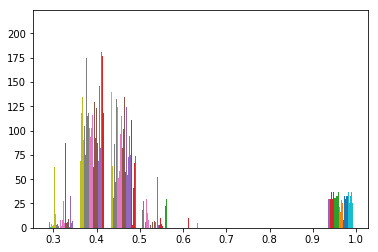

ValueError: array must be 2-dimensional and square. shape = (243, 420)

In [407]:
plt.hist(similarityMatrix)
plt.show()
similarityMatrix, clusters = merge(similarityMatrix, p_spectral_sim, 6, 8)
plt.hist(similarityMatrix)
plt.show()

n_clusters = 11
predicted_clusters = SpectralClustering(n_clusters=n_clusters, affinity="precomputed").fit_predict(itml.transform(X))
evaluate(X, y, predicted_clusters, n_clusters, "after merging")




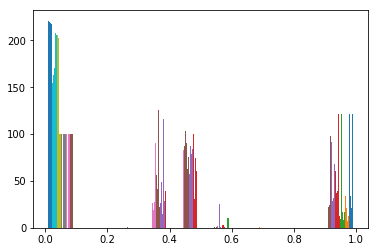

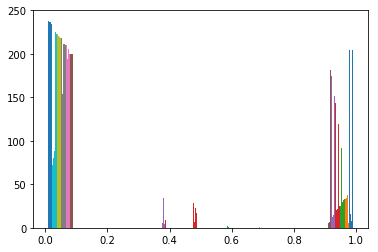

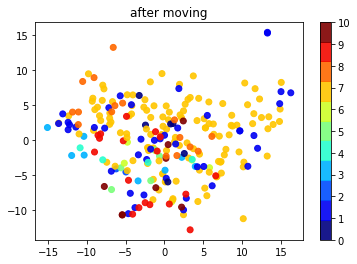

V-Measure = 0.48718855095565294


In [318]:
plt.hist(similarityMatrix)
plt.show()
for i in range(200):
    similarityMatrix, clusters = move(similarityMatrix, p_spectral_sim, i, 9)
plt.hist(similarityMatrix)
plt.show()

n_clusters = 11
predicted_clusters = SpectralClustering(n_clusters=n_clusters, affinity="precomputed").fit_predict(similarityMatrix)
evaluate(X, y, predicted_clusters, n_clusters, "after moving")



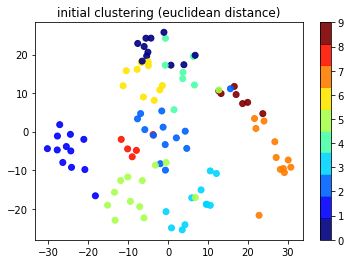

V-Measure = 0.8598674307167


In [68]:
#trying on digits
from PIL import Image
dist = euclidean_distance(scale(X))
sim = distance_to_similarity(dist)
n_clusters=10
pred = SpectralClustering(n_clusters=n_clusters, affinity="precomputed").fit_predict(sim)
evaluate(X, y, pred, n_clusters, "initial clustering (euclidean distance)")
#store_clusters('c:/clustering/result/', Image.fromarray(X[0,:], 'L'), pred, clear_directory=True)


itml iter: 0, conv = 11.231093
itml iter: 1, conv = 4.745355
itml iter: 2, conv = 1.774899
itml iter: 3, conv = 1.590393
itml iter: 4, conv = 0.952991
itml iter: 5, conv = 0.703851
itml iter: 6, conv = 0.529241
itml iter: 7, conv = 0.383872
itml iter: 8, conv = 0.288162
itml iter: 9, conv = 0.208421
itml iter: 10, conv = 0.154043
itml iter: 11, conv = 0.115610
itml iter: 12, conv = 0.086622
itml iter: 13, conv = 0.064373
itml iter: 14, conv = 0.047645
itml iter: 15, conv = 0.035029
itml iter: 16, conv = 0.026312
itml iter: 17, conv = 0.019807
itml iter: 18, conv = 0.014773
itml iter: 19, conv = 0.010996
itml iter: 20, conv = 0.008107
itml iter: 21, conv = 0.006083
itml iter: 22, conv = 0.004590
itml iter: 23, conv = 0.003440
itml iter: 24, conv = 0.002551
itml iter: 25, conv = 0.001886
itml iter: 26, conv = 0.001415
itml iter: 27, conv = 0.001069
itml converged at iter: 28, conv = 0.000803


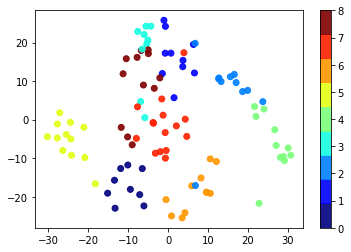

V-Measure = 0.7652073706883938


In [69]:

simCon, disCon = merge(pred, 1, 7)
sim = learn_distance(X, simCon,disCon)
n_clusters=9
pred = SpectralClustering(n_clusters=n_clusters, affinity="precomputed").fit_predict(sim)
evaluate(X, y, pred, n_clusters, "") 


In [127]:
#todo remove
def create_constraints(Y):
    import itertools
    import random
    
    # aggregate indices of same class
    zeros = np.where(Y==0)[0]
    ones = np.where(Y==1)[0]
    twos = np.where(Y==2)[0]
    # make permutations of all those points in the same class
    zeros_ = list(itertools.combinations(zeros, 2))
    ones_ = list(itertools.combinations(ones, 2))
    twos_ = list(itertools.combinations(twos, 2))
    # put them together!
    sim = np.array(zeros_ + ones_ + twos_)
   
    # similarily, put together indices in different classes
    dis = []
    for zero in zeros:
        for one in ones:
            dis.append((zero, one))
        for two in twos:
            dis.append((zero, two))
    for one in ones:
        for two in twos:
            dis.append((one, two))
            
    # pick up just enough dissimilar examples as we have similar examples
    dis = np.array(random.sample(dis, int(len(sim))))
    # return a four-tuple of arrays with d(X[a],X[b])<d(X[c],X[d])
    return sim[:,0], sim[:,1], dis[:,0], dis[:,1]
from metric_learn import ITML
ITML().fit(X, constraints=create_constraints(np.array([0,0,0,0,0,0,1,1,1,1,1,2,2,2])))
create_constraints(np.array([0,0,0,0,0,0,1,1,1,1,1,2,2,2]))

(array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  3,  3,  4,  6,  6,
         6,  6,  7,  7,  7,  8,  8,  9, 11, 11, 12], dtype=int64),
 array([ 1,  2,  3,  4,  5,  2,  3,  4,  5,  3,  4,  5,  4,  5,  5,  7,  8,
         9, 10,  8,  9, 10,  9, 10, 10, 12, 13, 13], dtype=int64),
 array([ 9,  0,  2,  2,  4,  0,  1,  1,  9,  0, 10,  2,  8,  4,  4,  0,  5,
         2,  4,  2,  3,  8,  5,  1,  5,  1,  1,  0], dtype=int64),
 array([11, 12, 10,  6, 13, 13,  6, 13, 13,  9, 13, 12, 12, 11, 10, 11,  7,
        11,  9,  8, 10, 13,  6,  7, 11, 11, 12, 10], dtype=int64))

## Clustering handwritten digits

Shape = (1797, 64)


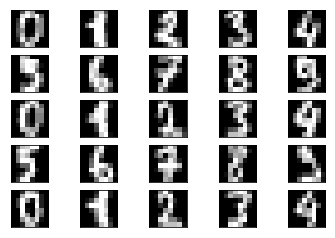

In [6]:
from sklearn.datasets import load_digits
digits = load_digits()
print(f'Shape = {digits.data.shape}')

import matplotlib.pyplot as plt
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.show()

X = digits.data[:100] # use only the first 100 samples to speed things up
y = digits.target[:100]


### Calculate distance/similarity 

In [490]:
n_samples = X.shape[0]

distanceMatrix = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(n_samples):
        distanceMatrix[i, j] = np.linalg.norm(X[i, :] - X[j, :]) # initialize with euclidean distance
        
# sklearn proposes to use similarity isntead of distance for spectral clustering
beta = .5 # .5 seems to yield the best results, in paper they use 1
similarityMatrix = np.exp(-beta * distanceMatrix / (distanceMatrix.std()**2))  # formula in paper squares the std

### comparison of kmeans & spectral clustering w/ and w/o PCA

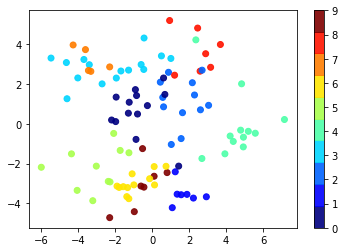

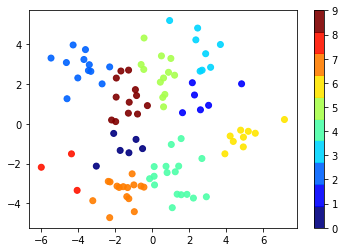

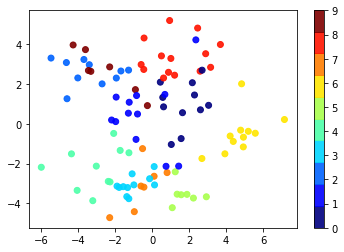

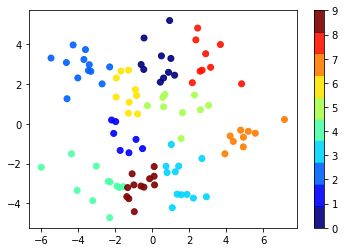

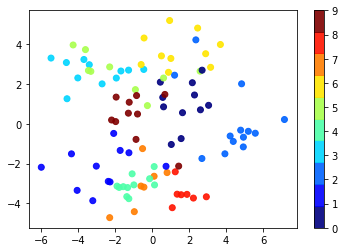

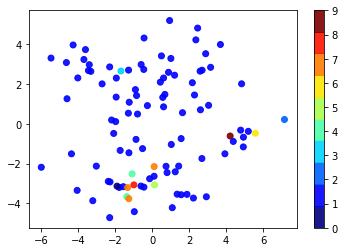

In [480]:

from sklearn.cluster import KMeans, SpectralClustering, spectral_clustering
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from matplotlib import cm

X = scale(X)
Xreduced = PCA(n_components=2).fit_transform(X)

n_clusters = 10


pk = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(X)
pkr = KMeans(n_clusters=n_clusters, random_state=0).fit_predict(Xreduced)
ps = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors").fit_predict(X)
psr = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors").fit_predict(Xreduced)
psa = SpectralClustering(n_clusters=n_clusters, affinity="precomputed").fit_predict(similarityMatrix)
psd = spectral_clustering(distanceMatrix,n_clusters=n_clusters) #bad!


cmap = cm.get_cmap('jet', lut=n_clusters)
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=pk, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=pkr, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=ps, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=psr, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=psa, cmap=cmap, alpha=.9)
plt.colorbar()
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=psd, cmap=cmap, alpha=.9)
plt.colorbar()



### using affinity matrix described in paper, using euclidean distance to start

## Evaluation

In [481]:
from sklearn import metrics

print(metrics.v_measure_score(y, pk))
print(metrics.v_measure_score(y, pkr))
print(metrics.v_measure_score(y, ps))
print(metrics.v_measure_score(y, psr))
print(metrics.v_measure_score(y, psa))
print(metrics.v_measure_score(y, psd))
# --> clearly we get better results by not reducing the data before clustering! (which was expected)

0.8446550318271264
0.5897815886150143
0.8749912989222266
0.6134524825321745
0.8928735102768438
0.19962985639751252


## Cluster Adjustments

In [491]:
def merge(similarityMatrix, clusters, a, b):
    # expects clusters to be list of labels, a and b label to be merged
    clusters[clusters == b] = a
    for i in range(n_samples):
        for j in range(n_samples):
            if (clusters[i] == clusters[j]):
                similarityMatrix[i,j] = 1 #TODO what exactly should we do here? increase similarity, or set it to fixed val?



{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

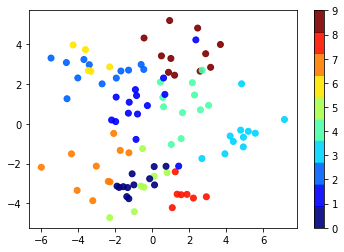

In [492]:
## usecase: merge clusters
n_clusters = 10
p = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=1).fit_predict(similarityMatrix)
cmap = cm.get_cmap('jet', lut=n_clusters)
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=p, cmap=cmap, alpha=.9)
plt.colorbar()

set(p)

In [493]:
merge(similarityMatrix, p, 0, 5)
print(set(p))

{0, 1, 2, 3, 4, 6, 7, 8, 9}


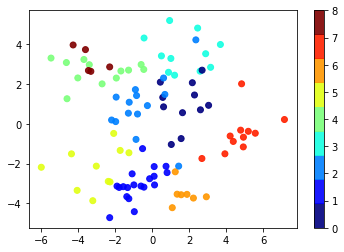

In [495]:
n_clusters = 9
p = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=1).fit_predict(similarityMatrix)
cmap = cm.get_cmap('jet', lut=n_clusters)
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=p, cmap=cmap, alpha=.9)
plt.colorbar()

In [496]:
merge(similarityMatrix, p, 1,7)
print(set(p))

{0, 1, 2, 3, 4, 5, 6, 8}


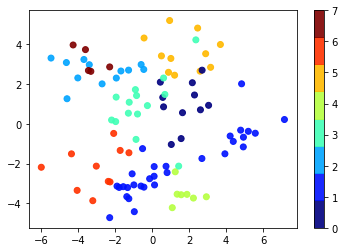

In [497]:
n_clusters = 8
p = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=1).fit_predict(similarityMatrix)
cmap = cm.get_cmap('jet', lut=n_clusters)
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=p, cmap=cmap, alpha=.9)
plt.colorbar()



In [501]:
merge(similarityMatrix, p, 2,7)
print(set(p))

{0, 1, 2, 3, 4, 5, 6}


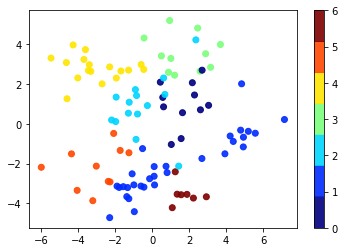

In [502]:
n_clusters = 7
p = SpectralClustering(n_clusters=n_clusters, affinity="precomputed", random_state=1).fit_predict(similarityMatrix)
cmap = cm.get_cmap('jet', lut=n_clusters)
plt.figure()
plt.scatter(Xreduced[:, 0], Xreduced[:, 1], c=p, cmap=cmap, alpha=.9)
plt.colorbar()



# The SKlearn example, using kmeans with dimensionality reduction (PCA) for digit clustering

In [101]:

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.28s	69432	0.602	0.650	0.625	0.465	0.598	0.146
random   	0.23s	69694	0.669	0.710	0.689	0.553	0.666	0.147
PCA-based	0.03s	70804	0.671	0.698	0.684	0.561	0.668	0.118
__________________________________________________________________________________


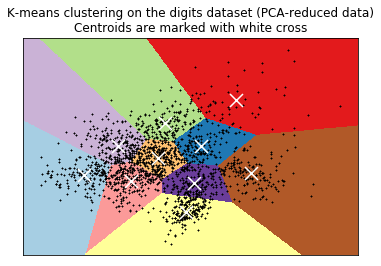

In [133]:
# Visualization

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k+', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()